In [ ]:
# !pip install -qr colab_requirements.txt

# Read data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path


data_dir  = Path('data/csv')

train_fp  = data_dir/'train.csv'
dev_fp    = data_dir/'dev.csv'
test_fp   = data_dir/'test.csv'


def read_csv(csv_path):
    assert csv_path.is_file()
    df = pd.read_csv(csv_path)

    X = df.pop('review')
    y = df.replace({
        np.nan: 0, 
        'negative': 1, 
        'neutral': 2, 
        'positive': 3}) \
        .astype(np.uint8)

    print(csv_path.name, 'X.shape:', X.shape, 'y.shape:', y.shape)
    return X, y

X_train, y_train = read_csv(train_fp)
X_dev, y_dev = read_csv(dev_fp)
X_test, y_test = read_csv(test_fp)

train.csv X.shape: (2961,) y.shape: (2961, 12)
dev.csv X.shape: (1290,) y.shape: (1290, 12)
test.csv X.shape: (500,) y.shape: (500, 12)



# EDA

Số nhãn từng lớp trong tập train


<AxesSubplot:>

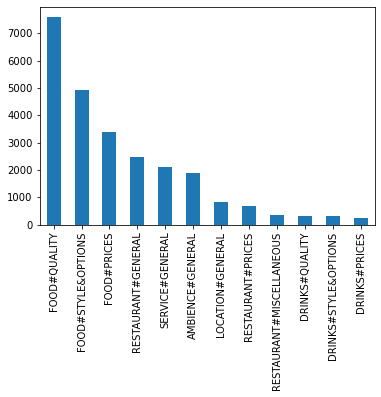

In [2]:
print('Số nhãn từng lớp trong tập train')
count_aspects = (~~y_train).sum(axis=0).sort_values(ascending=False)
count_aspects.plot.bar()

# Tiền xử lí dữ liệu

In [44]:
import re
import emoji
from sklearn.base import BaseEstimator, TransformerMixin


class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self, num_step=range(7)):
        self.num_step = num_step

        self.re_emoji = emoji.get_emoji_regexp()
        self.re_hagtag = re.compile('#\S+')
        self.re_giatien = re.compile('((?:(?:\d+[,\.]?)+) ?(?:k|vnd|d|đ|củ))')
        self.re_special_chars = re.compile('[@!#$&^*%<>?/=+`]')
        khong = 'k|K|hong|Ko|ko|Khg|khg|Khong|khong'
        self.re_khong = re.compile(f'(?:^|(?<= ))({khong})(?:(?= )|$)')

    def step0(self, text):
        """Thay #lozi, #blabla thành hag_tag
        """
        return self.re_hagtag.sub(' hag_tag ', text)

    def step1(self, text):
        """Thay 100k, 200d thành 'gia_tien'. 
        """
        return self.re_giatien.sub(' giá_tiền ', text)

    def step2(self, text):
        """Xóa kí tự đặc biệt
        """
        return self.re_special_chars.sub('', text)

    def step3(self, text):
        """Xóa emoji 🍿
        """
        return self.re_emoji.sub('', text)

    def step4(self, text):
        """đổi các từ phủ định sau: khong, ko, khg, k… thành không
        """
        return self.re_khong.sub('không', text)

    def step5(self, text):
        """phân thành token và pos tagging sử dụng thư viện Pyvi
        """
        return text

    def step6(self, text):
        """Loại bỏ tên đồ ăn và thức uống
        """
        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = np.empty((len(X),), dtype=object)

        steps = np.array([self.step0,
                          self.step1,
                          self.step2,
                          self.step3,
                          self.step4,
                          self.step5,
                          self.step6])

        for i, text in enumerate(X):
            for step in steps[self.num_step]:
                text = step(text)
            result[i] = text

        return result

    def __call__(self, X):
        return self.transform(X)


In [45]:
texts = [
    'K khí trong lành. đồ ăn hong ngon, thức uống  K tồi; 🥙🌮',
    'khung cảnh xinh đẹp',
    '200k quá mắc',
    'món ăn này mắc quá tới 200k lận. ngày 23/3/2000 😴',
    'mua 100.000vnd',
    'bán 1,000,000 d. 5 cái bành xèo tốn 500k',
    'bán 1.000.000 d. 5 cái bành xèo tốn 500k %^^4',
    'món ăn này có giá 10 lít',
    'món ăn này tận 1 củ',
    'bán 1.000đ',
    'quán này có giá trung bình từ 100k-200k 😛',
    'quán này có giá trung bình từ 100-200k 😫',
    '#mắc #food',
    'bàn ghế sạch đẹp, thái độ nhân viên ok#restaurant 😍',
    '#tiktok ở nhà vẫn vui',
    '# birthday ngày mai có tiệc ^^',
    'aslkdhlakd#tiktok#learn asljdalskjd',
    '#tiktok   #learn',
    '#hastag alskjdlasjd #hastag asdsadas #hastag 😁',
    '#123&456',
    '#!?@!',
]


preprocess = Preprocess()
preprocess(texts)

array(['không khí trong lành. đồ ăn không ngon, thức uống  không tồi; ',
       'khung cảnh xinh đẹp', ' giá_tiền  quá mắc',
       'món ăn này mắc quá tới  giá_tiền  lận. ngày 2332000 ',
       'mua  giá_tiền ', 'bán  giá_tiền . 5 cái bành xèo tốn  giá_tiền ',
       'bán  giá_tiền . 5 cái bành xèo tốn  giá_tiền  4',
       'món ăn này có giá 10 lít', 'món ăn này tận  giá_tiền ',
       'bán  giá_tiền ',
       'quán này có giá trung bình từ  giá_tiền - giá_tiền  ',
       'quán này có giá trung bình từ 100- giá_tiền  ',
       ' hag_tag   hag_tag ',
       'bàn ghế sạch đẹp, thái độ nhân viên ok hag_tag  ',
       ' hag_tag  ở nhà vẫn vui', ' birthday ngày mai có tiệc ',
       'aslkdhlakd hag_tag  asljdalskjd', ' hag_tag     hag_tag ',
       ' hag_tag  alskjdlasjd  hag_tag  asdsadas  hag_tag  ', ' hag_tag ',
       ' hag_tag '], dtype=object)

# Models

In [46]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

## Model 0 (Random Forest)

In [48]:
model0 = make_pipeline(
    Preprocess([2, 3, 4]),
    TfidfVectorizer(),
    RandomForestClassifier(random_state=5)
)

model0.fit(X_train, y_train)

Pipeline(steps=[('preprocess', Preprocess(num_step=[2, 3, 4])),
                ('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=5))])

## Model 1 (Random Forest + Full Preprocess)

In [49]:
model1 = make_pipeline(
    Preprocess(),
    TfidfVectorizer(),
    RandomForestClassifier(random_state=5)
)

model1.fit(X_train, y_train)

Pipeline(steps=[('preprocess', Preprocess()),
                ('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=5))])

## Model 2 (SVM)

In [55]:
model2 = make_pipeline(
    Preprocess(),
    TfidfVectorizer(),
    MultiOutputClassifier(LinearSVC(random_state=5))
)

model2.fit(X_train, y_train)

Pipeline(steps=[('preprocess', Preprocess()),
                ('tfidfvectorizer', TfidfVectorizer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LinearSVC(random_state=5)))])

## Model 3(SVM)

In [ ]:
!pip install -q underthesea

In [ ]:
from underthesea import word_tokenize
vectorizer = TfidfVectorizer(
    tokenizer=(word_tokenize)
)

vectorizer.fit_transform([
    'chợ thịt chó nổi tiếng ở Sài Gòn bị truy quét'
])


# Evaluation

## Custom Evaluation Tool

In [51]:
from sklearn.metrics import f1_score

def multioutput_to_multilabel(y):
    if isinstance(y, pd.DataFrame): 
        y = y.values
    nrow = y.shape[0]
    ncol = y.shape[1]
    multilabel = np.zeros((nrow, 3 * ncol), dtype=bool)
    for i in range(nrow):
        for j in range(ncol):
            if y[i, j] != 0:
                pos = j * 3 + (y[i, j] - 1)
                multilabel[i, pos] = True
    return multilabel


def custom_f1_score(y_true, y_pred, average='micro', **kwargs):
    y_true = multioutput_to_multilabel(y_true)
    y_pred = multioutput_to_multilabel(y_pred)
    return f1_score(y_true, y_pred, average=average, **kwargs)


def custom_evaluate(model, X, y_true):
    y_pred = model.predict(X)
    return custom_f1_score(y_true, y_pred)

In [52]:
custom_evaluate(model0, X_dev, y_dev)

0.5819713563605728

In [53]:
custom_evaluate(model1, X_dev, y_dev)

0.5982934033475549

In [56]:
custom_evaluate(model2, X_dev, y_dev)

0.6493506493506493

## Official Evaluation Tool

In [ ]:
import json


sentiments = [None, 'negative', 'neutral', 'positive']

with open(data_dir/'aspects.json') as f:
    aspects = json.load(f)


def label_decoder(encoded_label):
    label = []
    for ap_idx, stm_idx in enumerate(encoded_label):
        if stm_idx != 0:
            aspect = aspects[ap_idx]
            sentiment = sentiments[stm_idx]
            label.append(f'{{{aspect}, {sentiment}}}')

    return ', '.join(label)


def save_result(X, y, save_path):
    rows = []
    for test_id, (review, encoded_label) in enumerate(zip(X, y), 1):
        label = label_decoder(encoded_label)
        rows.extend((f'#{test_id}', review, label, ''))

    text = '\n'.join(rows[:-1])
    with open(save_path, mode='w', encoding='utf-8-sig') as output_file:
        output_file.write(text)

    
def evaluate(model, X, y_true_path, y_pred_path):
    y = model.predict(X)
    save_result(X, y, y_pred_path)
    !java SAEvaluate.java {y_true_path} {y_pred_path}

### Evaluate on dev

In [ ]:
evaluate(model0, X_dev, "y_dev.txt", "y_pred_model0.txt")

In [ ]:
evaluate(model1, X_dev, "y_dev.txt", "y_pred_model1.txt")

In [ ]:
evaluate(model2, X_dev, "y_dev.txt", "y_pred_model2.txt")

### Evaluate on test

# Code nháp gõ dưới đây

In [ ]:
import re
import numpy as np
def transform_units_123(texts):
    return np.array([re.sub(r"[_@!#$&^*%<>?/=+`]",'',text) for text in texts])

In [ ]:
transform_units_123(['@ hên quá đi=, hôm nay cô không khảo bài ^'])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b5b5c153-f56a-4329-a053-06afe7378c69' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>